# cafe sales time series analysis
This notebook loads data and prepares the data for cafe sales time series analysis .

In [90]:
import pandas as pd
import numpy as np
print('Dataset is loaded for analysis')

Dataset is loaded for analysis


In [180]:
# load cafe sales dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/third/first semister/machine lear/mlproject/sales prediction model/dirty_cafe_sales.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


In [181]:
print(f'dataset shape:{df.shape}')
print(df.isnull().sum())

dataset shape:(10000, 8)
Transaction ID         0
Item                 333
Quantity             138
Price Per Unit       179
Total Spent          173
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64


In [182]:
#Numeric Columns: Convert Quantity, Price Per Unit, and Total Spent to numeric types:
df[['Quantity', 'Price Per Unit', 'Total Spent']] = df[['Quantity', 'Price Per Unit', 'Total Spent']].apply(pd.to_numeric, errors='coerce')
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce', format='%Y-%m-%d')

#Replace "UNKNOWN" and "ERROR" with NaN for consistency:
df.replace(['UNKNOWN', 'ERROR', 'UnKNOWN'], pd.NA, inplace=True)

In [183]:
# List of numeric columns
numeric_cols = ['Quantity', 'Price Per Unit', 'Total Spent']

# Fill missing values with the median of each column
# Fill missing values with the median of each numeric column
median_dict = {col: df[col].median() for col in numeric_cols}
df.fillna(median_dict, inplace=True)

In [184]:
# List of categorical columns
categorical_cols = ['Item', 'Payment Method', 'Location']

# Fill missing values with the mode (most frequent value) of each column
for col in categorical_cols:
    mode_value = df[col].mode().iloc[0]
    df[col] = df[col].fillna(mode_value)

# Categorical Data Standardization
categorical_cols = ['Item', 'Payment Method', 'Location']

for col in categorical_cols:
    df[col] = df[col].str.upper()

#Check for duplicate Transaction ID:
df.drop_duplicates(subset=['Transaction ID'], inplace=True)
df =df.dropna(subset=['Transaction Date'])

In [185]:
# data = pd.get_dummies(data, columns=['Payment Method', 'Location', 'Item'], drop_first=True)
df = pd.get_dummies(df, columns=['Payment Method', 'Location', 'Item'], drop_first=True)

In [186]:
# See how many missing values exist in each column
print(df.isnull().sum())

df.info()

Transaction ID                   0
Quantity                         0
Price Per Unit                   0
Total Spent                      0
Transaction Date                 0
Payment Method_CREDIT CARD       0
Payment Method_DIGITAL WALLET    0
Location_TAKEAWAY                0
Item_COFFEE                      0
Item_COOKIE                      0
Item_JUICE                       0
Item_SALAD                       0
Item_SANDWICH                    0
Item_SMOOTHIE                    0
Item_TEA                         0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 9540 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Transaction ID                 9540 non-null   object        
 1   Quantity                       9540 non-null   float64       
 2   Price Per Unit                 9540 non-null   float64       
 3   Total Spent         

In [187]:
outlier_info = {}

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Find outliers
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
    outlier_info[col] = {
        'outlier_count': outliers.shape[0],
        'percent_of_data': 100 * outliers.shape[0] / df.shape[0]
    }
# Show summary
import pprint
pprint.pprint(outlier_info)

{'Price Per Unit': {'outlier_count': 0, 'percent_of_data': 0.0},
 'Quantity': {'outlier_count': 0, 'percent_of_data': 0.0},
 'Total Spent': {'outlier_count': 250, 'percent_of_data': 2.620545073375262}}


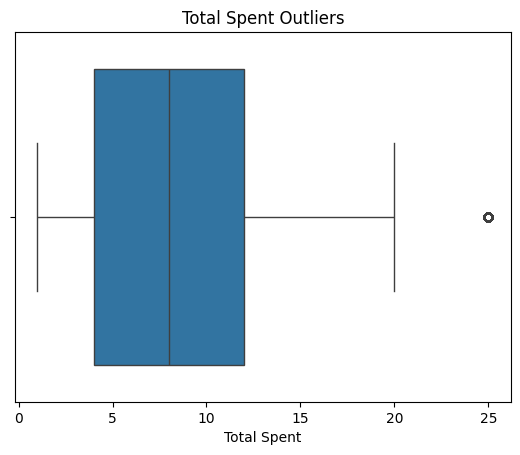

In [188]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(x=df['Total Spent'])
plt.title("Total Spent Outliers")
plt.show()

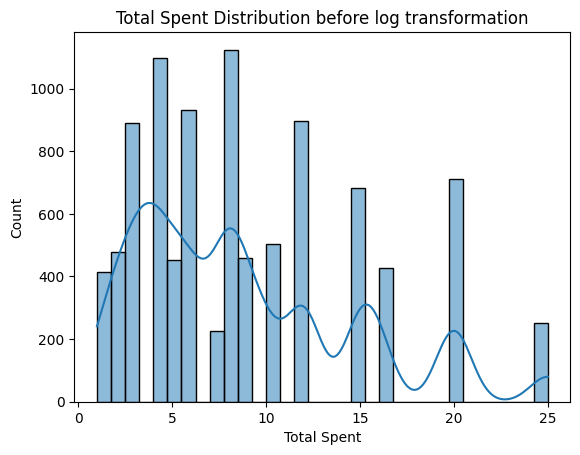

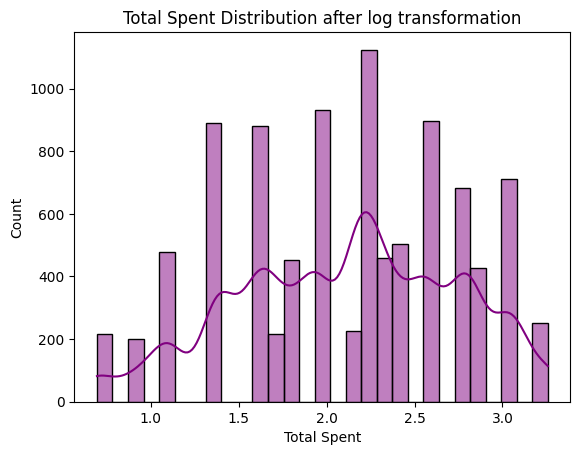

In [189]:
sns.histplot(df['Total Spent'], kde=True)
plt.title("Total Spent Distribution before log transformation")
plt.show()

df['Total Spent'] = np.log1p(df['Total Spent'])
plt.title("Total Spent Distribution after log transformation")
sns.histplot(df['Total Spent'], kde=True,color="purple")
plt.show()


In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9540 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Transaction ID                 9540 non-null   object        
 1   Quantity                       9540 non-null   float64       
 2   Price Per Unit                 9540 non-null   float64       
 3   Total Spent                    9540 non-null   float64       
 4   Transaction Date               9540 non-null   datetime64[ns]
 5   Payment Method_CREDIT CARD     9540 non-null   bool          
 6   Payment Method_DIGITAL WALLET  9540 non-null   bool          
 7   Location_TAKEAWAY              9540 non-null   bool          
 8   Item_COFFEE                    9540 non-null   bool          
 9   Item_COOKIE                    9540 non-null   bool          
 10  Item_JUICE                     9540 non-null   bool          
 11  Item_SALAD            

In [191]:
missing = pd.date_range(df.index.min(), df.index.max()).difference(df.index)
print("Missing dates:", len(missing))
print(f'duplicate check:{df.index.duplicated().sum()}')

Missing dates: 1
duplicate check:0


In [192]:
df = df.sort_values('Transaction Date')
df.set_index('Transaction Date', inplace=True)

daily_sales = df['Total Spent'].resample('D').sum()

In [193]:
df.drop(columns=['Transaction ID'], inplace=True)
df.head(10)

,Quantity,Price Per Unit,Total Spent,Payment Method_CREDIT CARD,Payment Method_DIGITAL WALLET,Location_TAKEAWAY,Item_COFFEE,Item_COOKIE,Item_JUICE,Item_SALAD,Item_SANDWICH,Item_SMOOTHIE,Item_TEA
Transaction Date,,,,,,,,,,,,,
2023-01-01,1.0,3.0,1.386294,False,True,True,False,False,True,False,False,False,False
2023-01-01,2.0,4.0,2.197225,False,True,False,False,False,False,False,False,True,False
2023-01-01,5.0,1.5,2.197225,False,True,True,False,False,False,False,False,False,True
2023-01-01,5.0,3.0,3.044522,False,True,False,False,False,False,False,True,False,False
2023-01-01,5.0,3.0,2.772589,False,True,True,False,False,True,False,False,False,False
2023-01-01,4.0,3.0,2.564949,False,True,True,False,False,True,False,False,False,False
2023-01-01,3.0,5.0,2.397895,False,True,True,False,False,False,True,False,False,False
2023-01-01,5.0,4.0,3.044522,False,False,False,False,False,False,False,True,False,False
2023-01-01,3.0,1.5,1.704748,False,True,False,False,False,False,False,False,False,True


In [194]:
import pandas as pd

# Assume df is your DataFrame
# 'Transaction Date' is already the index, so we access it via df.index
# df['Transaction Date'] = pd.to_datetime(df['Transaction Date']) # This line is no longer needed

# Extract day of year
df['DayOfYear'] = df.index.dayofyear

# Extract month
df['Month'] = df.index.month

# Optional: extract day of month and weekday
df['Day'] = df.index.day
df['Weekday'] = df.index.weekday  # Monday=0

In [195]:
daily_sales = df.groupby('Transaction Date').agg({'Total Spent':'sum'}).reset_index()
daily_sales.set_index('Transaction Date', inplace=True)

In [196]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9540 entries, 2023-01-01 to 2023-12-31
Data columns (total 17 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Quantity                       9540 non-null   float64
 1   Price Per Unit                 9540 non-null   float64
 2   Total Spent                    9540 non-null   float64
 3   Payment Method_CREDIT CARD     9540 non-null   bool   
 4   Payment Method_DIGITAL WALLET  9540 non-null   bool   
 5   Location_TAKEAWAY              9540 non-null   bool   
 6   Item_COFFEE                    9540 non-null   bool   
 7   Item_COOKIE                    9540 non-null   bool   
 8   Item_JUICE                     9540 non-null   bool   
 9   Item_SALAD                     9540 non-null   bool   
 10  Item_SANDWICH                  9540 non-null   bool   
 11  Item_SMOOTHIE                  9540 non-null   bool   
 12  Item_TEA                      

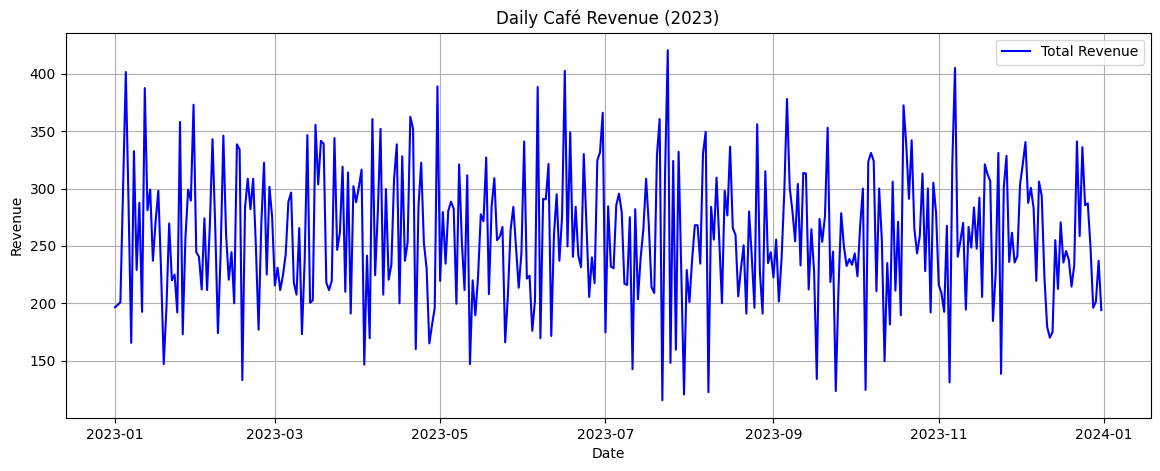

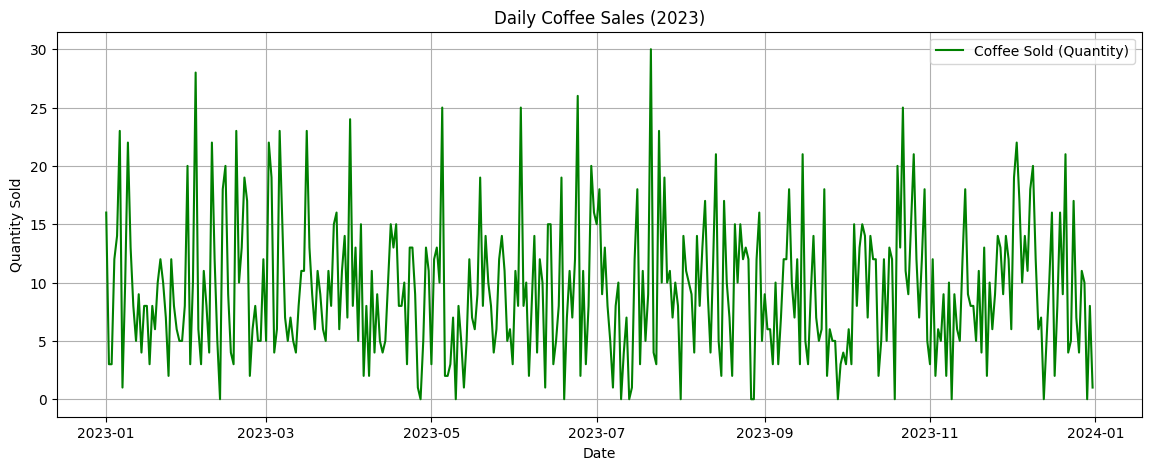

In [197]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# 1. Convert log revenue back to actual revenue
# -------------------------------
df['Total Spent'] = np.exp(df['Total Spent'])

# -------------------------------
# 2. Ensure 'Transaction Date' is a column
# -------------------------------
if 'Transaction Date' not in df.columns and df.index.name == 'Transaction Date':
    df.reset_index(inplace=True)

# -------------------------------
# 3. Convert to datetime and sort
# -------------------------------
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'])
df = df.sort_values('Transaction Date')
df.set_index('Transaction Date', inplace=True)

# -------------------------------
# 4. Aggregate daily sales
# -------------------------------
daily_sales = df['Total Spent'].resample('D').sum()

# -------------------------------
# 5. Aggregate daily coffee quantity
# -------------------------------
coffee_daily = df[df['Item_COFFEE'] == True]['Quantity'].resample('D').sum().fillna(0)

# -------------------------------
# 6. Plot total daily revenue
# -------------------------------
plt.figure(figsize=(14,5))
plt.plot(daily_sales, color='blue', label='Total Revenue')
plt.title("Daily Café Revenue (2023)")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.grid(True)
plt.legend()
plt.show()

# -------------------------------
# 7. Plot daily coffee sales
# -------------------------------
plt.figure(figsize=(14,5))
plt.plot(coffee_daily, color='green', label='Coffee Sold (Quantity)')
plt.title("Daily Coffee Sales (2023)")
plt.xlabel("Date")
plt.ylabel("Quantity Sold")
plt.grid(True)
plt.legend()
plt.show()

/tmp/ipython-input-3737002870.py:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = df['Total Spent'].resample('M').sum()


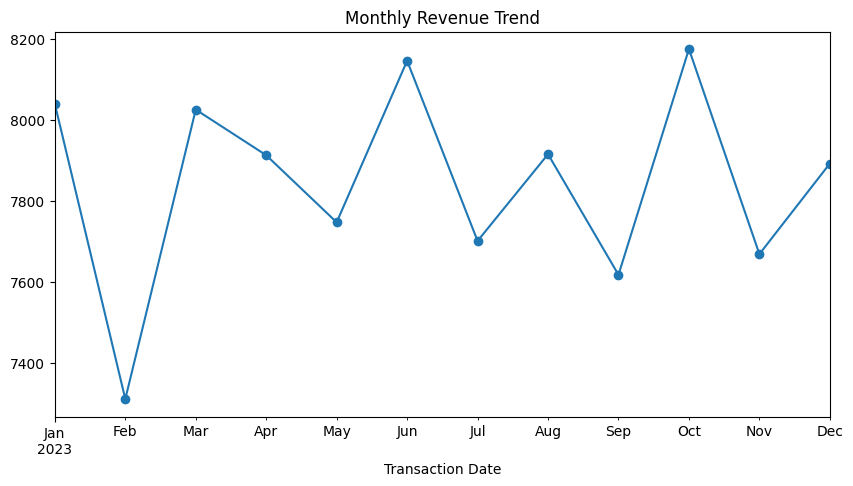

day_name
Friday        9.835735
Monday        9.799928
Saturday      9.818851
Sunday        9.874275
Thursday      9.958333
Tuesday      10.120519
Wednesday     9.680835
Name: Total Spent, dtype: float64


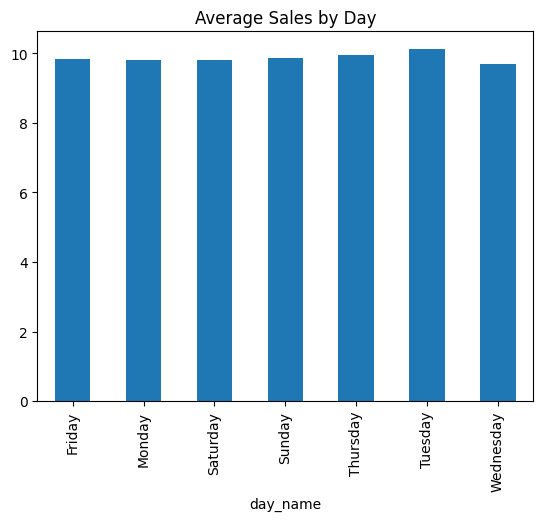

In [198]:
monthly_sales = df['Total Spent'].resample('M').sum()

monthly_sales.plot(marker='o', figsize=(10,5))
plt.title("Monthly Revenue Trend")
plt.show()

df['day_name'] = df.index.day_name()

weekday_sales = df.groupby('day_name')['Total Spent'].mean()
print(weekday_sales)

weekday_sales.plot(kind='bar')
plt.title("Average Sales by Day")
plt.show()

Missing dates: 0
check null value:0
outlier checking:


<Axes: >

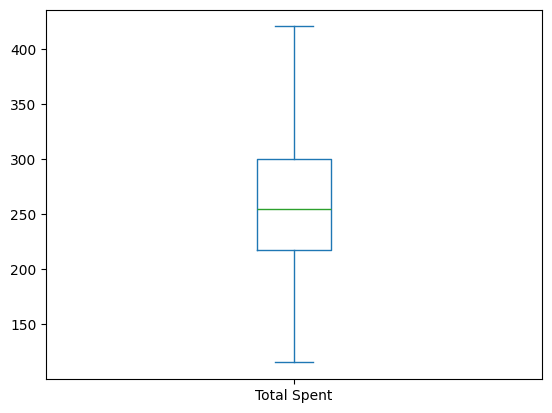

In [199]:
missing = pd.date_range(df.index.min(), df.index.max()).difference(df.index)
print("Missing dates:", len(missing))

print(f'check null value:{daily_sales.isna().sum()}')

# check outlier
print('outlier checking:')
daily_sales.plot.box()

In [200]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf

print("========== TIME SERIES DIAGNOSTIC REPORT ==========\n")

# ensure daily aggregation
ts = df['Total Spent'].resample('D').sum().fillna(0)

# -------------------------------
# 1. BASIC STRUCTURE
# -------------------------------
print("1️⃣ BASIC STRUCTURE")
print("Total observations:", len(ts))
print("Date range:", ts.index.min(), "to", ts.index.max())

missing_dates = pd.date_range(ts.index.min(), ts.index.max()).difference(ts.index)
print("Missing dates:", len(missing_dates))

duplicates = ts.index.duplicated().sum()
print("Duplicate dates:", duplicates)

# Interpretation
if len(missing_dates)==0 and duplicates==0:
    print("✔ Time continuity: GOOD\n")
else:
    print("⚠ Fix missing/duplicate dates\n")

# -------------------------------
# 2. MISSING VALUES
# -------------------------------
print("2️⃣ MISSING VALUES")
print("Missing values:", ts.isna().sum())

if ts.isna().sum()==0:
    print("✔ No missing values\n")
else:
    print("⚠ Fill missing values\n")

# -------------------------------
# 3. OUTLIER CHECK (IQR METHOD)
# -------------------------------
print("3️⃣ OUTLIERS")
q1, q3 = ts.quantile([0.25, 0.75])
iqr = q3 - q1
upper = q3 + 1.5 * iqr
outliers = (ts > upper).sum()

print("Outliers:", outliers)
print("Percent outliers:", round(outliers/len(ts)*100,2), "%")

if outliers/len(ts) < 0.05:
    print("✔ Outliers acceptable\n")
else:
    print("⚠ Many outliers — consider capping\n")

# -------------------------------
# 4. TREND STRENGTH
# -------------------------------
print("4️⃣ TREND STRENGTH")
trend_strength = ts.corr(pd.Series(range(len(ts)), index=ts.index))
print("Trend correlation:", round(trend_strength,3))

if abs(trend_strength) < 0.3:
    print("✔ Weak trend")
elif abs(trend_strength) < 0.6:
    print("✔ Moderate trend")
else:
    print("✔ Strong trend")
print()

# -------------------------------
# 5. WEEKLY SEASONALITY
# -------------------------------
print("5️⃣ WEEKLY SEASONALITY")
weekly_var = ts.groupby(ts.index.dayofweek).mean().std()
overall_var = ts.std()

seasonality_strength = weekly_var / overall_var
print("Seasonality strength:", round(seasonality_strength,3))

if seasonality_strength > 0.25:
    print("✔ Strong weekly seasonality\n")
else:
    print("✔ Weak weekly seasonality\n")

# -------------------------------
# 6. STATIONARITY (ADF TEST)
# -------------------------------
print("6️⃣ STATIONARITY (ADF TEST)")
adf_result = adfuller(ts)
p_value = adf_result[1]
print("ADF p-value:", round(p_value,4))

if p_value < 0.05:
    print("✔ Stationary (ARIMA ready)\n")
else:
    print("⚠ Non-stationary → differencing recommended\n")

# -------------------------------
# 7. AUTOCORRELATION
# -------------------------------
print("7️⃣ AUTOCORRELATION")
acf_vals = acf(ts, nlags=7)
autocorr_strength = acf_vals[1]

print("Lag-1 autocorrelation:", round(autocorr_strength,3))

if autocorr_strength > 0.5:
    print("✔ Strong dependence on previous day\n")
elif autocorr_strength > 0.2:
    print("✔ Moderate dependence\n")
else:
    print("✔ Weak dependence\n")

# -------------------------------
# 8. VOLATILITY LEVEL
# -------------------------------
print("\n8️⃣ VOLATILITY")
cv = ts.std() / ts.mean()
print("Coefficient of Variation:", round(cv,3))

if cv < 0.3:
    print("✔ Stable series")
elif cv < 0.6:
    print("✔ Moderate variability")
else:
    print("⚠ Highly volatile data")

print("\n========== DIAGNOSTIC COMPLETE ==========")

========== TIME SERIES DIAGNOSTIC REPORT ==========

1️⃣ BASIC STRUCTURE
Total observations: 365
Date range: 2023-01-01 00:00:00 to 2023-12-31 00:00:00
Missing dates: 0
Duplicate dates: 0
✔ Time continuity: GOOD

2️⃣ MISSING VALUES
Missing values: 0
✔ No missing values

3️⃣ OUTLIERS
Outliers: 0
Percent outliers: 0.0 %
✔ Outliers acceptable

4️⃣ TREND STRENGTH
Trend correlation: -0.023
✔ Weak trend

5️⃣ WEEKLY SEASONALITY
Seasonality strength: 0.085
✔ Weak weekly seasonality

6️⃣ STATIONARITY (ADF TEST)
ADF p-value: 0.0
✔ Stationary (ARIMA ready)

7️⃣ AUTOCORRELATION
Lag-1 autocorrelation: -0.087
✔ Weak dependence


8️⃣ VOLATILITY
Coefficient of Variation: 0.226
✔ Stable series

========== DIAGNOSTIC COMPLETE ==========



=== MODEL ACCURACY LAST 30 DAYS ===
                  MAE   RMSE   MAPE
Naive           59.02  70.50  27.26
Moving Average  45.13  52.86  19.99
Holt-Winters    43.09  50.05  18.13
ARIMA           42.37  49.65  17.94
SARIMA          43.10  50.05  18.13
Random Forest   22.14  26.98   8.98

🏆 Best Model (by RMSE): Random Forest

=== LAST 30 DAYS COMPARISON ===
         Date  Actual  Naive  Moving Avg  Holt-Winters   ARIMA  SARIMA  \
0  2023-12-02   321.0  303.5      272.43        253.08  252.91  249.00   
1  2023-12-03   340.5  303.5      272.43        255.01  259.06  257.62   
2  2023-12-04   287.5  303.5      272.43        260.15  258.31  259.30   
3  2023-12-05   300.5  303.5      272.43        254.47  258.40  254.59   
4  2023-12-06   283.0  303.5      272.43        250.02  258.39  249.61   
5  2023-12-07   219.5  303.5      272.43        266.27  258.39  265.57   
6  2023-12-08   306.0  303.5      272.43        261.12  258.39  262.23   
7  2023-12-09   293.5  303.5      272.43       

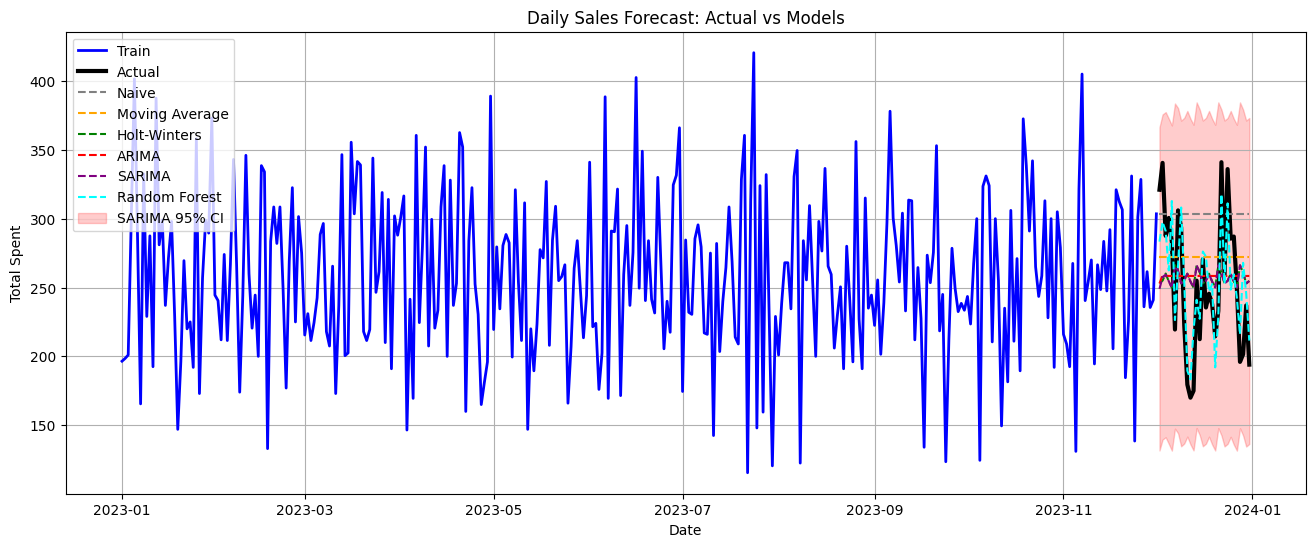

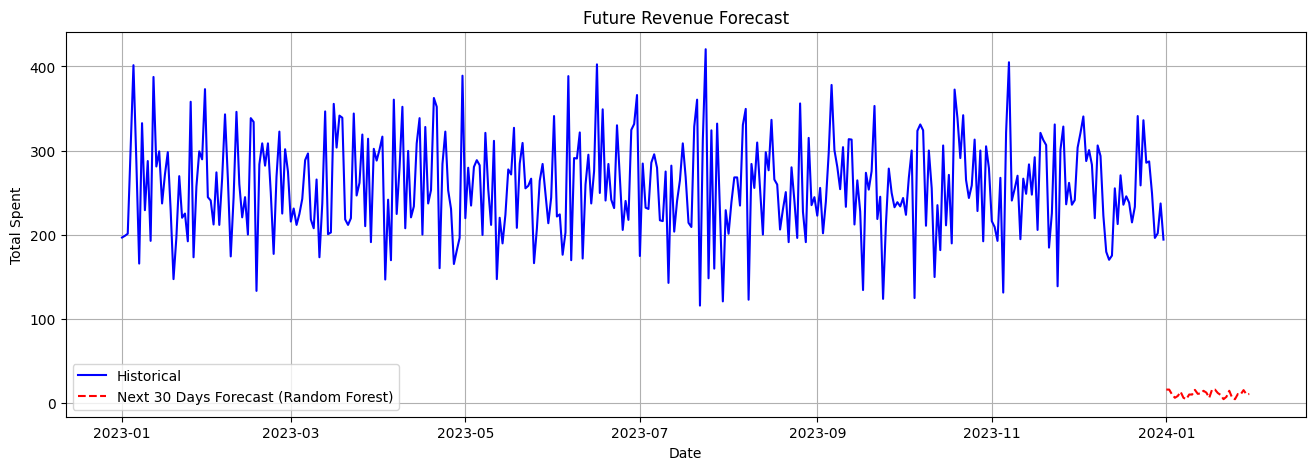

In [203]:
# ==========================================================
# COMBINED CAFE SALES FORECAST: TS + ML + VISUAL + NUMBERS
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----------------------------------------------------------
# 1. PREPARE DAILY TIME SERIES
# ----------------------------------------------------------
df = df.sort_index()
daily_sales = df['Total Spent'].resample('D').sum().fillna(0)

# ----------------------------------------------------------
# 2. TRAIN/TEST SPLIT
# ----------------------------------------------------------
forecast_days = 30
train_ts = daily_sales[:-forecast_days]
test_ts = daily_sales[-forecast_days:]

# ----------------------------------------------------------
# 3. DEFINE METRICS
# ----------------------------------------------------------
def evaluate(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    mape = np.mean(np.abs((actual - predicted)/actual))*100
    return mae, rmse, mape

# ----------------------------------------------------------
# 4. TIME SERIES MODELS
# ----------------------------------------------------------

# 4a. Naive
naive_forecast = np.repeat(train_ts.iloc[-1], forecast_days)

# 4b. Moving Average (7 days)
moving_avg_value = train_ts.rolling(7).mean().iloc[-1]
moving_avg_forecast = np.repeat(moving_avg_value, forecast_days)

# 4c. Holt-Winters (additive weekly seasonality)
hw_model = ExponentialSmoothing(
    train_ts,
    trend='add',
    seasonal='add',
    seasonal_periods=7
).fit()
hw_forecast = hw_model.forecast(forecast_days)

# 4d. ARIMA
arima_model = ARIMA(train_ts, order=(1,1,1)).fit()
arima_forecast = arima_model.forecast(forecast_days)

# 4e. SARIMA
sarima_model = SARIMAX(train_ts, order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast = sarima_fit.get_forecast(steps=forecast_days)
sarima_pred = sarima_forecast.predicted_mean
sarima_ci = sarima_forecast.conf_int()

# ----------------------------------------------------------
# 5. RANDOM FOREST MODEL
# ----------------------------------------------------------
# Features (categorical already one-hot encoded, plus time features)
features = ['DayOfYear','Month','Day','Weekday',
            'Payment Method_CREDIT CARD','Payment Method_DIGITAL WALLET',
            'Location_TAKEAWAY','Item_COFFEE','Item_COOKIE','Item_JUICE',
            'Item_SALAD','Item_SANDWICH','Item_SMOOTHIE','Item_TEA']

# Ensure these exist in df
X = df[features]
y = df['Total Spent']

# Train-test split sequentially
train_size = int(len(df)*0.9)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Aggregate RF predictions daily
rf_daily_pred_df = pd.DataFrame({'Total Spent': y_pred_rf}, index=X_test.index)
rf_pred_aligned = rf_daily_pred_df.resample('D').sum().reindex(test_ts.index).fillna(0)['Total Spent']

# ----------------------------------------------------------
# 6. EVALUATE ALL MODELS
# ----------------------------------------------------------
models = {
    "Naive": naive_forecast,
    "Moving Average": moving_avg_forecast,
    "Holt-Winters": hw_forecast.values,
    "ARIMA": arima_forecast.values,
    "SARIMA": sarima_pred.values,
    "Random Forest": rf_pred_aligned.values
}

results = {}
for name, forecast in models.items():
    mae, rmse, mape = evaluate(test_ts.values, forecast)
    results[name] = {"MAE": mae, "RMSE": rmse, "MAPE": mape}

# Print numeric results
print("\n=== MODEL ACCURACY LAST 30 DAYS ===")
results_df = pd.DataFrame(results).T.round(2)
print(results_df)

# Select best model (lowest RMSE)
best_model_name = results_df['RMSE'].idxmin()
print("\n🏆 Best Model (by RMSE):", best_model_name)

# ----------------------------------------------------------
# 7. LAST 30 DAYS: ACTUAL VS FORECAST (NUMBERS)
# ----------------------------------------------------------
numbers_df = pd.DataFrame({
    "Date": test_ts.index,
    "Actual": test_ts.values,
    "Naive": naive_forecast,
    "Moving Avg": moving_avg_forecast,
    "Holt-Winters": hw_forecast.values,
    "ARIMA": arima_forecast.values,
    "SARIMA": sarima_pred.values,
    "Random Forest": rf_pred_aligned.values
})
print("\n=== LAST 30 DAYS COMPARISON ===")
print(numbers_df.round(2))

# ----------------------------------------------------------
# 8. PLOT: ACTUAL VS ALL FORECASTS
# ----------------------------------------------------------
plt.figure(figsize=(16,6))
plt.plot(train_ts.index, train_ts, label='Train', color='blue', linewidth=2)
plt.plot(test_ts.index, test_ts, label='Actual', color='black', linewidth=3)

colors = ['gray','orange','green','red','purple','cyan']
for i, (name, forecast) in enumerate(models.items()):
    plt.plot(test_ts.index, forecast, label=name, color=colors[i], linestyle='--')

# SARIMA CI
plt.fill_between(sarima_ci.index, sarima_ci.iloc[:,0], sarima_ci.iloc[:,1], color='red', alpha=0.2, label='SARIMA 95% CI')

plt.xlabel('Date')
plt.ylabel('Total Spent')
plt.title('Daily Sales Forecast: Actual vs Models')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# 9. FUTURE FORECAST USING BEST MODEL
# ----------------------------------------------------------
future_days = 30
if best_model_name == "Holt-Winters":
    future_forecast = hw_model.forecast(future_days)
elif best_model_name == "ARIMA":
    future_forecast = arima_model.forecast(future_days)
elif best_model_name == "SARIMA":
    future_forecast = sarima_fit.get_forecast(steps=future_days).predicted_mean
elif best_model_name == "Random Forest":
    future_X = X[-future_days:]  # last days as proxy
    future_forecast = rf_model.predict(future_X)
else:  # Naive / Moving Avg
    future_forecast = np.repeat(train_ts.iloc[-1], future_days)

future_dates = pd.date_range(daily_sales.index[-1]+pd.Timedelta(days=1), periods=future_days)
future_df = pd.Series(future_forecast, index=future_dates, name='Forecast')

plt.figure(figsize=(16,5))
plt.plot(daily_sales, label='Historical', color='blue')
plt.plot(future_df, label=f'Next {future_days} Days Forecast ({best_model_name})', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total Spent')
plt.title('Future Revenue Forecast')
plt.legend()
plt.grid(True)
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


=== MODEL ACCURACY LAST 30 DAYS ===
SARIMA:       MAE=42.30, RMSE=49.50, MAPE=17.87%
Hybrid SARIMA+RF: MAE=12.98, RMSE=16.58, MAPE=5.36%

=== LAST 30 DAYS COMPARISON ===
         Date  Actual  SARIMA  Hybrid_RF
0  2023-12-02   321.0  251.92     301.65
1  2023-12-03   340.5  259.00     325.94
2  2023-12-04   287.5  262.06     290.35
3  2023-12-05   300.5  256.18     285.44
4  2023-12-06   283.0  250.63     281.38
5  2023-12-07   219.5  260.84     209.33
6  2023-12-08   306.0  262.49     291.24
7  2023-12-09   293.5  255.78     314.43
8  2023-12-10   222.5  255.75     209.40
9  2023-12-11   179.5  263.09     170.56
10 2023-12-12   170.0  255.96     200.21
11 2023-12-13   175.0  251.18     162.89
12 2023-12-14   255.0  261.56     277.55
13 2023-12-15   212.5  260.97     222.89
14 2023-12-16   270.5  255.92     275.83
15 2023-12-17   235.5  255.61     231.52
16 2023-12-18   245.5  263.12     233.84
17 2023-12-19   238.0  255.94     251.88
18 2023-12-20   214.5  251.19     204.21
19 2023-12

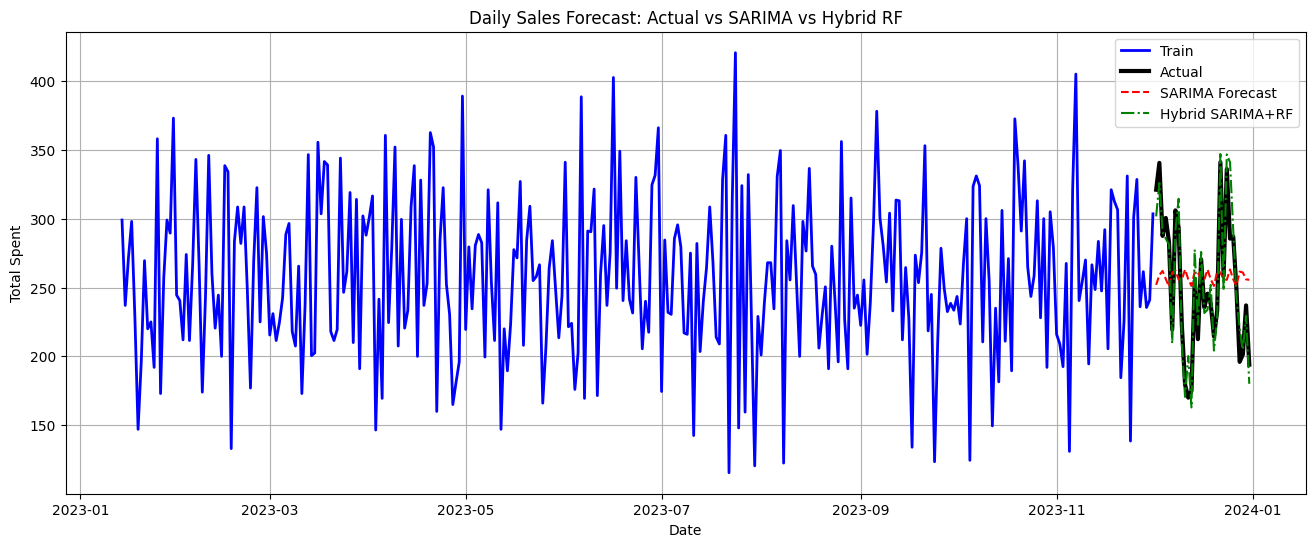

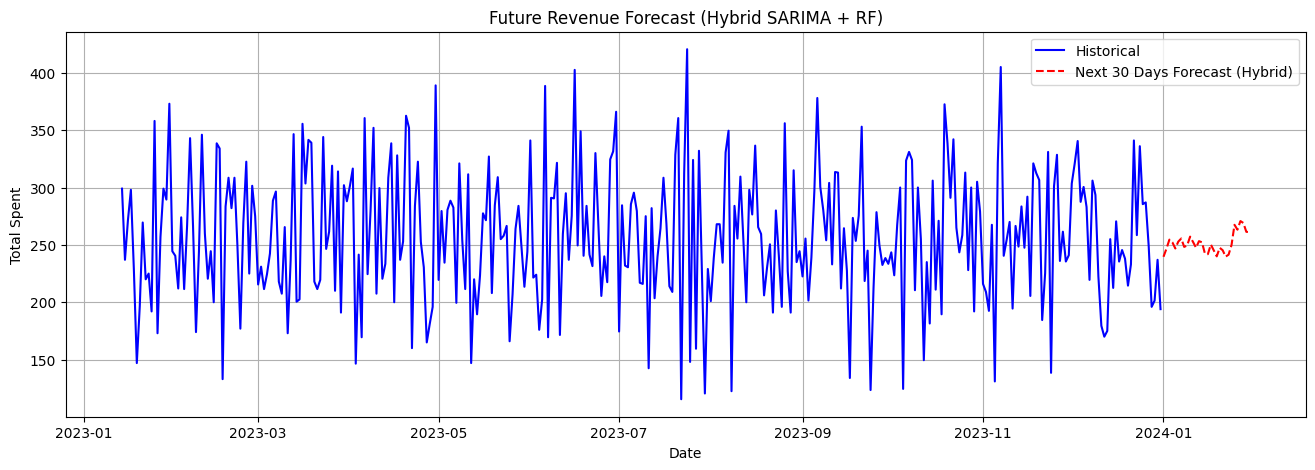

In [208]:
# ==========================================================
# HYBRID SALES FORECAST: SARIMA + RANDOM FOREST + LAGS
# ==========================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ----------------------------------------------------------
# 1. PREPARE DAILY TIME SERIES AND AGGREGATED FEATURES
# ----------------------------------------------------------
# Ensure df is sorted by index (transaction-level DataFrame)
df = df.sort_index()

# Aggregate numeric columns in df to daily sums/means
agg_dict = {
    'Total Spent': 'sum',
    'Quantity': 'sum',
    'Price Per Unit': 'mean', # Use mean for price per unit
    'DayOfYear': 'first', # These features are constant for a given day
    'Month': 'first',
    'Day': 'first',
    'Weekday': 'first',
}
# Add one-hot encoded categorical features - sum will count true occurrences
categorical_cols_in_df = [col for col in df.columns if col.startswith(('Payment Method_', 'Location_', 'Item_'))]
for col in categorical_cols_in_df:
    agg_dict[col] = 'sum'

df_daily_aggregated = df.groupby(df.index).agg(agg_dict).rename(columns={'Total Spent': 'Daily_Total_Spent'})
# Now df_daily_aggregated has unique daily dates as its index and is truly daily aggregated.

# Add cyclical features for RF model (now on the daily aggregated data)
df_daily_aggregated['Month_sin'] = np.sin(2*np.pi*df_daily_aggregated['Month']/12)
df_daily_aggregated['Month_cos'] = np.cos(2*np.pi*df_daily_aggregated['Month']/12)
df_daily_aggregated['Weekday_sin'] = np.sin(2*np.pi*df_daily_aggregated['Weekday']/7)
df_daily_aggregated['Weekday_cos'] = np.cos(2*np.pi*df_daily_aggregated['Weekday']/7)

# ----------------------------------------------------------
# 2. ADD LAG & ROLLING FEATURES (on daily aggregated data)
# ----------------------------------------------------------
lags = [1,2,3,7]
for lag in lags:
    df_daily_aggregated[f'Daily_Total_Spent_lag{lag}'] = df_daily_aggregated['Daily_Total_Spent'].shift(lag)

df_daily_aggregated['MA7'] = df_daily_aggregated['Daily_Total_Spent'].rolling(7).mean()
df_daily_aggregated['MA14'] = df_daily_aggregated['Daily_Total_Spent'].rolling(14).mean()

# Drop rows with NaN values created by lags/rolling features
df_combined_cleaned = df_daily_aggregated.dropna()

# The actual daily sales time series for SARIMA and evaluation
daily_sales_for_ts = df_combined_cleaned['Daily_Total_Spent']

# ----------------------------------------------------------
# 3. TRAIN/TEST SPLIT
# ----------------------------------------------------------
forecast_days = 30
train_ts = daily_sales_for_ts[:-forecast_days] # For SARIMA modeling
test_ts = daily_sales_for_ts[-forecast_days:]  # Actuals for evaluation

# Features (X) and target (y) for Random Forest
features_all = [col for col in df_combined_cleaned.columns if col != 'Daily_Total_Spent']
X = df_combined_cleaned[features_all]
y = df_combined_cleaned['Daily_Total_Spent']

train_size = len(train_ts)
X_train = X.loc[train_ts.index] # Align X_train with train_ts index
X_test = X.loc[test_ts.index]   # Align X_test with test_ts index
y_train = y.loc[train_ts.index] # Align y_train with train_ts index
y_test = y.loc[test_ts.index]   # Align y_test with test_ts index

# ----------------------------------------------------------
# 4. SARIMA MODEL (TREND + SEASONALITY)
# ----------------------------------------------------------
# SARIMA should now be trained on the truly daily aggregated series
sarima_model = SARIMAX(train_ts, order=(1,1,1), seasonal_order=(1,1,1,7))
sarima_fit = sarima_model.fit(disp=False)
sarima_forecast_train = sarima_fit.fittedvalues # These will align with train_ts
sarima_forecast_test = sarima_fit.get_forecast(steps=forecast_days).predicted_mean
sarima_residuals = train_ts - sarima_forecast_train # Correctly compute residuals on daily series

# ----------------------------------------------------------
# 5. RANDOM FOREST ON SARIMA RESIDUALS
# ----------------------------------------------------------
rf_model = RandomForestRegressor(n_estimators=500, random_state=42)
rf_model.fit(X_train, sarima_residuals)

# Predict residuals for test period
rf_residual_pred_series = pd.Series(rf_model.predict(X_test), index=X_test.index)

# Final hybrid forecast = SARIMA + RF residuals
hybrid_forecast = sarima_forecast_test + rf_residual_pred_series
# Ensure hybrid_forecast index aligns with test_ts (already should be from X_test.index and sarima_forecast_test.index)

# ----------------------------------------------------------
# 6. EVALUATE MODELS
# ----------------------------------------------------------
def evaluate(actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    # Handle cases where actual can be zero to prevent division by zero in MAPE
    mape = np.mean(np.abs((actual - predicted)/actual.replace(0, np.nan).ffill()))*100 # Fixed deprecated fillna
    return mae, rmse, mape

mae_sarima, rmse_sarima, mape_sarima = evaluate(test_ts, sarima_forecast_test)
mae_rf, rmse_rf, mape_rf = evaluate(test_ts, hybrid_forecast)

print("=== MODEL ACCURACY LAST 30 DAYS ===")
print(f"SARIMA:       MAE={mae_sarima:.2f}, RMSE={rmse_sarima:.2f}, MAPE={mape_sarima:.2f}%")
print(f"Hybrid SARIMA+RF: MAE={mae_rf:.2f}, RMSE={rmse_rf:.2f}, MAPE={mape_rf:.2f}%")

# ----------------------------------------------------------
# 7. LAST 30 DAYS NUMERIC COMPARISON
# ----------------------------------------------------------
comparison_df = pd.DataFrame({
    "Date": test_ts.index,
    "Actual": test_ts.values,
    "SARIMA": sarima_forecast_test.values,
    "Hybrid_RF": hybrid_forecast.values
})
print("\n=== LAST 30 DAYS COMPARISON ===")
print(comparison_df.round(2))

# ----------------------------------------------------------
# 8. PLOT: ACTUAL VS FORECASTS
# ----------------------------------------------------------
plt.figure(figsize=(16,6))
plt.plot(train_ts.index, train_ts, label='Train', color='blue', linewidth=2)
plt.plot(test_ts.index, test_ts, label='Actual', color='black', linewidth=3)
plt.plot(sarima_forecast_test.index, sarima_forecast_test, label='SARIMA Forecast', color='red', linestyle='--')
plt.plot(hybrid_forecast.index, hybrid_forecast, label='Hybrid SARIMA+RF', color='green', linestyle='-.')
plt.title('Daily Sales Forecast: Actual vs SARIMA vs Hybrid RF')
plt.xlabel('Date')
plt.ylabel('Total Spent')
plt.legend()
plt.grid(True)
plt.show()

# ----------------------------------------------------------
# 9. FUTURE 30 DAYS FORECAST
# ----------------------------------------------------------
future_dates = pd.date_range(daily_sales_for_ts.index[-1] + pd.Timedelta(days=1), periods=forecast_days)

# SARIMA future forecast
sarima_future = sarima_fit.get_forecast(steps=forecast_days).predicted_mean

# Generate future features for Random Forest iteratively
future_X_data_list = []

# Prepare historical data for lags and rolling means
# Ensure current_history is mutable
current_history = list(daily_sales_for_ts.iloc[-max(lags + [14]):].values) # Enough history for all lags and MA14

# Get mode of categorical features from training data for future predictions
# Assuming categorical_cols_in_df is correctly defined from earlier (it is in the top of this cell)
mode_categorical_features = {col: X_train[col].mode()[0] for col in categorical_cols_in_df}

for i in range(forecast_days):
    current_date = future_dates[i]

    future_feats_dict = {
        'Quantity': df_combined_cleaned['Quantity'].mean(), # Using mean of training data or a reasonable default
        'Price Per Unit': df_combined_cleaned['Price Per Unit'].mean(), # Using mean of training data or a reasonable default
        'DayOfYear': current_date.dayofyear,
        'Month': current_date.month,
        'Day': current_date.day,
        'Weekday': current_date.weekday(), # Corrected: call the method to get integer
        'Month_sin': np.sin(2*np.pi*current_date.month/12),
        'Month_cos': np.cos(2*np.pi*current_date.month/12),
        'Weekday_sin': np.sin(2*np.pi*current_date.weekday()/7), # Corrected: call the method
        'Weekday_cos': np.cos(2*np.pi*current_date.weekday()/7), # Corrected: call the method
    }

    # Dynamically populate lagged features and rolling means using current_history
    future_feats_dict['Daily_Total_Spent_lag1'] = current_history[-1]
    future_feats_dict['Daily_Total_Spent_lag2'] = current_history[-2] if len(current_history) >= 2 else current_history[0]
    future_feats_dict['Daily_Total_Spent_lag3'] = current_history[-3] if len(current_history) >= 3 else current_history[0]
    future_feats_dict['Daily_Total_Spent_lag7'] = current_history[-7] if len(current_history) >= 7 else current_history[0]

    # Calculate MA7 and MA14 using current_history
    future_feats_dict['MA7'] = np.mean(current_history[-7:]) if len(current_history) >= 7 else np.mean(current_history)
    future_feats_dict['MA14'] = np.mean(current_history[-14:]) if len(current_history) >= 14 else np.mean(current_history)

    # For categorical features, use the stored modes
    future_feats_dict.update(mode_categorical_features)

    future_X_data_list.append(future_feats_dict)

    # Predict the SARIMA residual for the current future_X row
    # Create a temporary DataFrame for current prediction to match X_train columns
    current_future_X_row = pd.DataFrame([future_feats_dict], columns=features_all)
    rf_current_residual_pred = rf_model.predict(current_future_X_row)[0]

    # Calculate hybrid future forecast for the current day
    current_hybrid_forecast_value = sarima_future.iloc[i] + rf_current_residual_pred

    # Update history with the current day's hybrid forecast for the next iteration's lags/rolling means
    current_history.append(current_hybrid_forecast_value)

# Convert list of dicts to DataFrame outside the loop
future_X = pd.DataFrame(future_X_data_list, index=future_dates, columns=features_all)

# Predict future residuals (already done iteratively in the loop)
# Combine sarima_future and the iteratively generated rf_future_residual_series (which is implicitly part of current_history)
# The `current_history` now contains the iteratively calculated hybrid forecasts.
# Extract the future part from `current_history`
hybrid_future = pd.Series(current_history[-forecast_days:], index=future_dates)

future_df = pd.Series(hybrid_future, index=future_dates, name='Forecast')

plt.figure(figsize=(16,5))
plt.plot(daily_sales_for_ts, label='Historical', color='blue') # Plot daily_sales_for_ts (clean aggregated data)
plt.plot(future_df, label='Next 30 Days Forecast (Hybrid)', color='red', linestyle='--')
plt.title('Future Revenue Forecast (Hybrid SARIMA + RF)')
plt.xlabel('Date')
plt.ylabel('Total Spent')
plt.legend()
plt.grid(True)
plt.show()